## Problem Statement
Boston Housing - Prices of house properties are given along with their characteristics -
1. CRIM: Per capita crime rate by town
2. ZN: Proportion of residential land zoned for lots over 25,000 sq. ft.
3. INDUS: Proportion of non-retail business acres per town
4. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5. NOX - Nitric oxides concentration (parts per 10 million)
6. RM - Average number of rooms per dwelling
7. AGE - Proportion of owner-occupied units built prior to 1940
8. DIS - Weighted distances to five Boston employment centres
9. RAD - Index of accessibility to radial highways
10. TAX - Full-value property-tax rate per 10,000 dollars
11. PTRATIO - Pupil-teacher ratio by town
12. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT - % lower status of the population
14. MEDV - Median value of owner-occupied homes in $1000's

## Goal
1. Analysis of the data - understanding the characteristics of the properties
2. Prediction - predicting prices of new house properties based on their characteristics

## Description


*   Features: [CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, B, LSTAT]
*   Target: MEDV



In [103]:
# importing libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import random
import copy

In [104]:
# functions required

def get_k_fold_cv(k, random_state, X, y):
  kfold = KFold(n_splits = k, shuffle = True, random_state = random_state)
  spl = kfold.split(X)
  return spl

# forward stepwise selection
def forward_selection(X_train, y_train, X_test, y_test):
  selected_features = []
  selected_features_list = []
  r2_test_list = []
  all_features = list(X_train.columns)
  remaining_features = list(X_train.columns)
  # print(f"All Features: {all_features}")
  p = X_train.shape[1]
  m0 = np.mean(y_train)
  result = []
  for k in range(p):
    temp_features = selected_features
    best_r_squared_train = float('-inf')
    best_feature = None
    best_model = None
    # print(f"K = {k}")
    for feature in remaining_features:
      # print(f"current feature: {feature}")
      temp_features.append(feature)
      X_train_subset = X_train.loc[:, temp_features]
      X_train_subset = sm.add_constant(X_train_subset)
      # print(f"Training features: {list(X_train_subset.columns)}")
      model = sm.OLS(y_train, X_train_subset).fit()
      r_squared_train = model.rsquared
      # print(f"Best R-Squared and R-Squared-train after adding current feature: {best_r_squared_train}, {r_squared_train}")
      if r_squared_train > best_r_squared_train:
        best_r_squared_train = r_squared_train
        best_feature = feature
        best_model = model
      temp_features.remove(feature)
      # print(f"Current best feature: {best_feature}")
    selected_features.append(best_feature)
    # print(f"Selected features: {selected_features}")
    remaining_features.remove(best_feature)
    # print(f"Remaining features: {remaining_features}")

    X_test_subset = X_test.loc[:, selected_features]
    X_test_subset = sm.add_constant(X_test_subset)
    y_pred = best_model.predict(X_test_subset)
    r2_test = r2_score(y_test, y_pred)
    result_k = [best_model, r2_test]
    result.append(result_k)
  return result, selected_features


def mixed_selection(X_train, y_train, X_test, y_test):
  selected_features = []
  selected_features_list = []
  r2_test_list = []
  all_features = list(X_train.columns)
  remaining_features = list(X_train.columns)
  # print(f"All Features: {all_features}")
  p = X_train.shape[1]
  m0 = np.mean(y_train)
  result = []
  for k in range(p):
    temp_features = selected_features
    best_r_squared_train = float('-inf')
    best_feature = None
    best_model = None
    # print(f"K = {k}")
    for feature in remaining_features:
      # print(f"current feature: {feature}")
      temp_features.append(feature)
      X_train_subset = X_train.loc[:, temp_features]
      X_train_subset = sm.add_constant(X_train_subset)
      # print(f"Training features: {list(X_train_subset.columns)}")
      model = sm.OLS(y_train, X_train_subset).fit()
      r_squared_train = model.rsquared
      # print(f"Best R-Squared and R-Squared-train after adding current feature: {best_r_squared_train}, {r_squared_train}")
      if r_squared_train > best_r_squared_train:
        best_r_squared_train = r_squared_train
        best_feature = feature
        best_model = model
      temp_features.remove(feature)
      # print(f"Current best feature: {best_feature}")
    selected_features.append(best_feature)
    # print(f"Selected features: {selected_features}")
    remaining_features.remove(best_feature)
    # print(f"Remaining features: {remaining_features}")

    X_test_subset = X_test.loc[:, selected_features]
    X_test_subset = sm.add_constant(X_test_subset)
    y_pred = best_model.predict(X_test_subset)
    r2_test = r2_score(y_test, y_pred)

    if k > 1:
      current_selected_features = selected_features.copy()
      best_r2_test_subset = float('-inf')
      temp_features1 = current_selected_features
      removed_features = []
      selected_features_length = len(selected_features)
      for k1 in range(selected_features_length):
        # print(f"Selected features length: {len(selected_features)}")
        # print(f"Value of K1: {k1}")
        # print(f"Best model features: {best_model.model.exog_names}")
        removed_feature = selected_features[k1]
        # print(f"removed feature: {removed_feature}")
        temp_features1 = [feature for feature in current_selected_features if feature != removed_feature]
        # print(f"Temp features in backward selection: {temp_features1}")
        X_train_subset = X_train.loc[:, temp_features1]
        X_train_subset = sm.add_constant(X_train_subset)
        model = sm.OLS(y_train, X_train_subset).fit()

        X_test_subset = X_test.loc[:, temp_features1]
        X_test_subset = sm.add_constant(X_test_subset)
        y_pred = model.predict(X_test_subset)
        r2_test_subset = r2_score(y_test, y_pred)

        if r2_test_subset > r2_test:
          # print("r2_Test_subset > r2_test")
          # print(f"Feature removed from selected features: {removed_feature}")
          current_selected_features.remove(removed_feature)
          # print(f"Selected features after removal: {current_selected_features}")
          better_subset_exists = True

        temp_features1 = current_selected_features
      selected_features = current_selected_features

  # print(f"Final selected features: {selected_features}")
  X_train_subset = X_train.loc[:, selected_features]
  X_train_subset = sm.add_constant(X_train_subset)
  model = sm.OLS(y_train, X_train_subset).fit()

  X_test_subset = X_test.loc[:, selected_features]
  X_test_subset = sm.add_constant(X_test_subset)
  y_pred = model.predict(X_test_subset)
  r2_test = r2_score(y_test, y_pred)
  return (model, r2_test, selected_features)

# backward selection to select features
def backward_selection(X_train, y_train, X_test, y_test):
  selected_features = list(X_train.columns)
  all_features = list(X_train.columns)
  # print(f"All Features: {all_features}")
  p = X_train.shape[1]
  result = []
  for k in range(p, 1, -1):
    temp_features = selected_features
    best_r_squared_train = float('-inf')
    worst_feature = None
    best_model = None
    # print(f"K = {k}")
    for feature in selected_features:
      # print(f"current feature: {feature}")
      temp_features.remove(feature)
      X_train_subset = X_train.loc[:, temp_features]
      X_train_subset = sm.add_constant(X_train_subset)
      # print(f"Training features: {list(X_train_subset.columns)}")
      model = sm.OLS(y_train, X_train_subset).fit()
      r_squared_train = model.rsquared
      # print(f"Best R-Squared and R-Squared-train after removing current feature: {best_r_squared_train}, {r_squared_train}")
      if r_squared_train > best_r_squared_train:
        best_r_squared_train = r_squared_train
        worst_feature = feature
        best_model = model
      temp_features.append(feature)
      # print(f"Current worst feature: {worst_feature}")
    selected_features.remove(worst_feature)
    # print(f"Selected features: {selected_features}")

    X_test_subset = X_test.loc[:, selected_features]
    X_test_subset = sm.add_constant(X_test_subset)
    # print(f"X_test_subset columns: {X_test_subset.columns}")
    # print(f"Best model details: {best_model.model.exog_names}, {best_model.rsquared}")
    y_pred = best_model.predict(X_test_subset)
    r2_test = r2_score(y_test, y_pred)
    # print(f"R-squared Test: {r2_test}")
    result_k = [best_model, r2_test]
    result.append(result_k)
  return result

In [105]:
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM',
          'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv("housing.csv", delim_whitespace=True, names = columns)
df.head(10)

/tmp/ipython-input-810203818.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("housing.csv", delim_whitespace=True, names = columns)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


In [106]:
target = 'MEDV'
features = [x for x in columns if x != target]

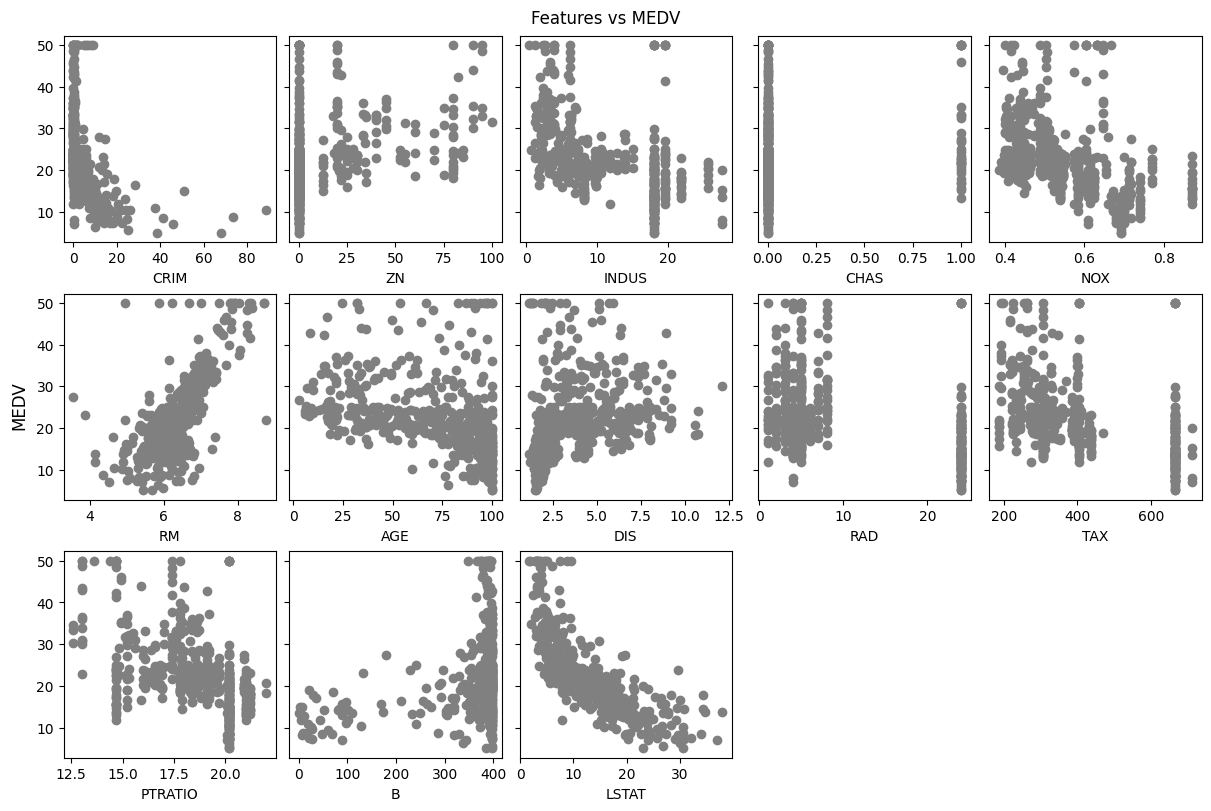

In [107]:
# Correlations between the features and the target
cols = 5
rows = 3
k = 0
fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (12, 8), layout = 'constrained', sharey = True)
for i in range(rows):
  for j in range(cols):
    if(k < len(features)):
      ax[i, j].scatter(df[features[k]], df[target], c = 'grey')
      ax[i, j].set_xlabel(features[k])
      k+=1
ax[2, 3].remove()
ax[2, 4].remove()
fig.supylabel(target)
fig.suptitle(f'Features vs {target}')
plt.show()

Comment: from "Features vs Target" graph, we can conclude the following:
1. CRIM vs MEDV - There is a negative correlation
2. ZN vs MEDV - Nothing can be said from the graph
3. INDUS vs MEDV - There is a negative correlation
4. CHAS vs MEDV - Nothing can be said from the graph
5. NOX vs MEDV - There is a negative correlation
6. RM vs MEDV - There is a positive correlation
7. AGE vs MEDV - There is a negative correlation
8. DIS vs MEDV - There is a positive correlation
9. RAD vs MEDV - There is a negative correlation
10. TAX vs MEDV - There is a negative correlation
11. PTRATIO vs MEDV - There is a negative correlation
12. B vs MEDV - There is a positive correlation
13. LSTAT vs MEDV - There is a negative correlation

In [108]:
correlations = df.corr()
print(correlations)

             CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
CRIM     1.000000 -0.200469  0.406583 -0.055892  0.420972 -0.219247  0.352734   
ZN      -0.200469  1.000000 -0.533828 -0.042697 -0.516604  0.311991 -0.569537   
INDUS    0.406583 -0.533828  1.000000  0.062938  0.763651 -0.391676  0.644779   
CHAS    -0.055892 -0.042697  0.062938  1.000000  0.091203  0.091251  0.086518   
NOX      0.420972 -0.516604  0.763651  0.091203  1.000000 -0.302188  0.731470   
RM      -0.219247  0.311991 -0.391676  0.091251 -0.302188  1.000000 -0.240265   
AGE      0.352734 -0.569537  0.644779  0.086518  0.731470 -0.240265  1.000000   
DIS     -0.379670  0.664408 -0.708027 -0.099176 -0.769230  0.205246 -0.747881   
RAD      0.625505 -0.311948  0.595129 -0.007368  0.611441 -0.209847  0.456022   
TAX      0.582764 -0.314563  0.720760 -0.035587  0.668023 -0.292048  0.506456   
PTRATIO  0.289946 -0.391679  0.383248 -0.121515  0.188933 -0.355501  0.261515   
B       -0.385064  0.175520 

Comment - Among the features, there are correlations, the stronger correlations(> 0.50) are between -
1. CRIM and RAD = 0.62  CRIM and TAX = 0.58
2. ZN and INDUS = -0.53, ZN and NOX = -0.51, ZN and AGE = -0.56, ZN and DIS = 0.66
3. INDUS and NOX = 0.76, INDUS and AGE = 0.64, INDUS and DIS = -0.70, INDUS and RAD = 0.59, INDUS and TAX = 0.72, INDUS and LSTAT = 0.60
4. NOX and AGE = 0.73, NOX and DIS = -0.76, NOX and RAD = 0.61, NOX and TAX = 0.66, NOX and LSTAT = 0.59
5. RM and LSTAT = -0.61
6. AGE and DIS = -0.74, AGE and TAX = 0.50, AGE and LSTAT = 0.60
7. DIS and TAX = -0.53
8. RAD and TAX = 0.91
9. TAX and LSTAT = 0.54

There is indication of strong multicollinearity

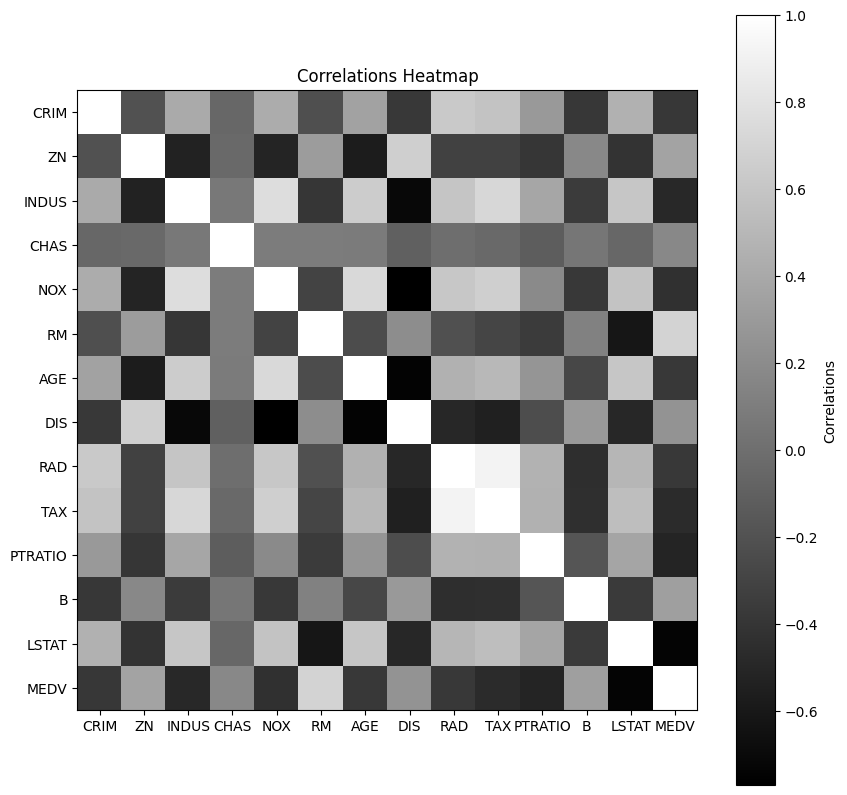

In [109]:
# Plotting heatmap
fig, ax = plt.subplots(figsize = (10, 10))
img = ax.imshow(correlations, cmap = 'grey')
ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns)
ax.set_yticks(np.arange(len(columns)))
ax.set_yticklabels(columns)
ax.figure.colorbar(img, label = 'Correlations', ax = ax)
plt.title('Correlations Heatmap')
plt.show()

In [110]:
# Basic statistics
print(f"Data Summary: \n{df.describe()}\n")
print(f"Data Shape: \n{df.shape}")

Data Summary: 
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.1

Comment - TAX and B have high variations (168 and 91)

### EDA - Exploratory Data Analysis - Analysing data to identify patterns, outliers

In [111]:
# coefficient of variation for different features - a relative measurement of dispersion
cv = (df.std() / df.mean()) * 100
print(cv)

CRIM       238.037610
ZN         205.237586
INDUS       61.600874
CHAS       367.202814
NOX         20.890339
RM          11.179921
AGE         41.048344
DIS         55.485809
RAD         91.181152
TAX         41.284120
PTRATIO     11.730604
B           25.596162
LSTAT       56.437413
MEDV        40.816505
dtype: float64


Comment - CRIM, ZN and CHAS has relatively high variations

Number of bins: 22


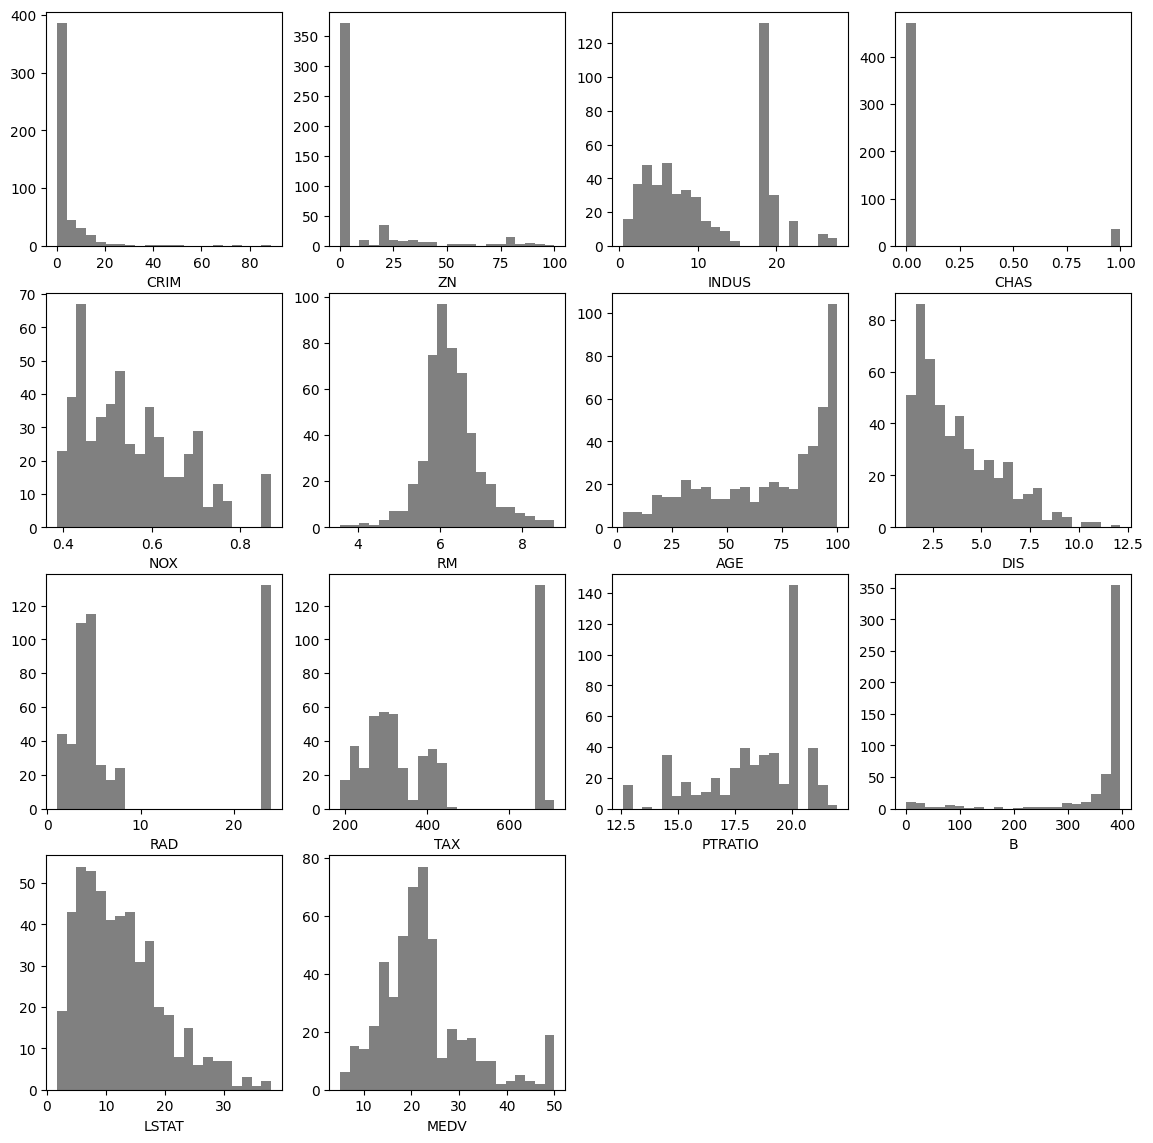

In [112]:
# Histogram of the features
number_of_bins = round(np.sqrt(df.shape[0]))
print(f"Number of bins: {number_of_bins}")
plt.figure(figsize = (14, 14))
i = 1
for column in df.columns:
  plt.subplot(4, 4, i)
  plt.hist(df[column], bins = number_of_bins, color = 'grey')
  plt.xlabel(column)
  i+=1
plt.show()

Comment -  
CRIM, ZN, INDUS, NOX, DIS, RAD, TAX, LSTAT are positively skewed  
AGE, B are negatively skewed  
RM, PTRATIO, MEDV looks normal approximately

In [113]:
# Implementation of Multiple Linear Regression
class LinearRegressionImpl:
  def compute_cost(self, X, y, w, b, lambda_ = 0):
    m, n = len(X), len(X[0])
    cost = 0.
    for i in range(m):
      f_wb_i = np.dot(X[i], w) + b
      cost += (f_wb_i - y[i]) ** 2
    cost /= (2 * m)
    return cost

  def compute_gradient(self, X, y, w, b, lambda_ = 0):
    m, n = len(X), len(X[0])
    dj_dw = np.zeros((n,))
    dj_db = 0.
    for i in range(m):
      f_wb_i = np.dot(w, X[i]) + b
      error = (f_wb_i - y[i])
      for j in range(n):
        dj_dw[j] += error * X[i][j]
      dj_db += error
    dj_dw /= m
    dj_db /= m
    for j in range(n):
      dj_dw[j] += (lambda_ / m ) * w[j]
    return dj_dw, dj_db

  def gradient_descent(self, X, y, w_init, b_init, alpha, num_iters, lambda_ = 0):
    cost_history = []
    cost_iters = []
    w = copy.deepcopy(w_init)
    b = b_init
    for i in range(num_iters):
      dj_dw, dj_db = self.compute_gradient(X, y, w, b, lambda_)
      w = w - alpha * dj_dw
      b = b - alpha * dj_db
      if(i % (num_iters/10) == 0 or i == (num_iters - 1)):
        cost = self.compute_cost(X, y, w, b)
        cost_history.append(cost)
        cost_iters.append(i+1)
        print(f"Cost for iteration: {i+1}: {cost}")
    return cost_history, cost_iters, w, b

In [114]:
def get_single_split(df, test_size = 0.1, random_state = 42):
  df_train_cv, df_test = train_test_split(df, test_size = test_size, random_state = 42)
  print(f"Train-Validation dataset shape: {df_train_cv.shape}")
  print(f"Test dataset shape: {df_test.shape}")
  X_test, y_test = df_test.loc[:, features], df_test.loc[:, target]
  X_train_cv, y_train_cv = df_train_cv.loc[:, features], df_train_cv.loc[:, target]

  return X_train_cv, X_test, y_train_cv, y_test

X_train_cv, X_test, y_train_cv, y_test = get_single_split(df, test_size = 0.1, random_state = 42)
X_train, X_cv = train_test_split(X_train_cv, test_size = 0.1, random_state = 42)
train_indices, cv_indices = X_train.index, X_cv.index
y_train, y_cv = y_train_cv[train_indices], y_train_cv[cv_indices]
print(f"Single split shapes: X_train: {X_train.shape}, X_cv: {X_cv.shape}, y_train: {y_train.shape}, y_cv: {y_cv.shape}")

Train-Validation dataset shape: (455, 14)
Test dataset shape: (51, 14)
Single split shapes: X_train: (409, 13), X_cv: (46, 13), y_train: (409,), y_cv: (46,)


In [115]:
def scale_features(X_train, X_cv):
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_cv_scaled = scaler.transform(X_cv)
  return X_train_scaled, X_cv_scaled
X_train_scaled, X_cv_scaled = scale_features(X_train, X_cv)

In [116]:
def verify_linear_regression_impl(X, y, learning_rate, lambda_, iterations):
  w_init = np.zeros(X.shape[1])
  b_init = 0
  regressor_impl = LinearRegressionImpl()
  cost_history, cost_iters, w_final, b_final = regressor_impl.gradient_descent(X, y, w_init, b_init, learning_rate, iterations, lambda_)
  print(f"w_final: {w_final}, b_final: {b_final}")
  return cost_history, cost_iters, w_final, b_final

def verify_regression_impl_without_regularization(X, y):
  alpha_ = 0.02
  iterations = 1000
  lambda_ = 0
  return verify_linear_regression_impl(X, y, alpha_, lambda_, iterations)

cost_history, cost_iters, w_final, b_final = verify_regression_impl_without_regularization(np.array(X_train_scaled), np.array(y_train))

Cost for iteration: 1: 282.87621942325654
Cost for iteration: 101: 16.93397737760722
Cost for iteration: 201: 12.134795059491374
Cost for iteration: 301: 11.8451332274944
Cost for iteration: 401: 11.732167537156066
Cost for iteration: 501: 11.66888757575305
Cost for iteration: 601: 11.630667919844335
Cost for iteration: 701: 11.606182400493937
Cost for iteration: 801: 11.589646124521485
Cost for iteration: 901: 11.577971053731638
Cost for iteration: 1000: 11.569509266378335
w_final: [-1.01302725  0.95689498 -0.09139769  0.6960646  -1.95628848  2.44892801
  0.16062237 -3.07217041  1.94374684 -1.14393508 -2.27755508  0.95639179
 -4.04778345], b_final: 22.530806808047156


Text(0, 0.5, 'Cost')

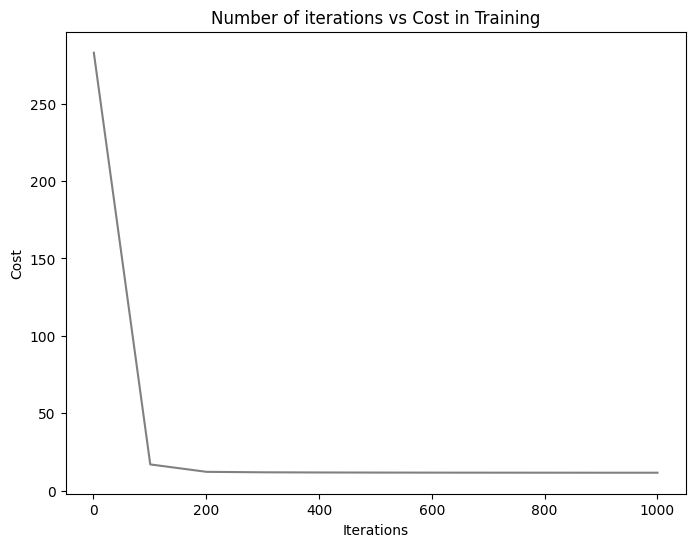

In [117]:
plt.figure(figsize = (8, 6))
plt.plot(cost_iters, cost_history, c = 'grey')
plt.title('Number of iterations vs Cost in Training')
plt.xlabel('Iterations')
plt.ylabel('Cost')

In [118]:
y_hat = np.dot(X_cv_scaled, w_final) + b_final
y_hat_train = np.dot(X_train_scaled, w_final) + b_final
print(f"R-squared CV: {r2_score(y_cv, y_hat)}")
print(f'MSE Train and CV data: {mean_squared_error(y_train, y_hat_train)}, {mean_squared_error(y_cv, y_hat)}')

R-squared CV: 0.7291892467954068
MSE Train and CV data: 23.139018532756687, 21.307713857603183


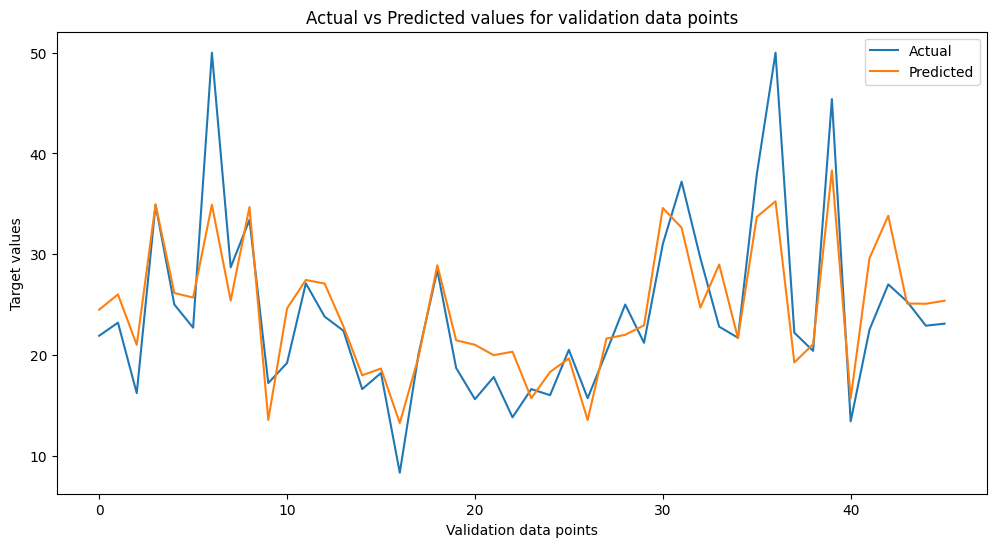

In [119]:
plt.figure(figsize = (12, 6))
plt.plot(range(len(y_cv)), y_cv, label = 'Actual')
plt.plot(range(len(y_cv)), y_hat, label = 'Predicted')
plt.xlabel('Validation data points')
plt.ylabel('Target values')
plt.title('Actual vs Predicted values for validation data points')
plt.legend()
plt.show()

In [120]:
lambdas_ = [0.01, 0.1, 5, 500, 5000]

def verify_regression_impl_with_regularization(X, y, lambda_ = 0):
  alpha_ = 0.02
  iterations = 1000
  return verify_linear_regression_impl(X, y, alpha_, lambda_, iterations)

lambdas_results = []
mse_cv_lambdas = []
mse_train_lambdas = []
y_pred_cv_lambdas = []
r2_cv_lambdas = []
for i in range(len(lambdas_)):
  print(f"Lambda value: {lambdas_[i]}")
  cost_history1, cost_iters1, w_final1, b_final1 = verify_regression_impl_with_regularization(np.array(X_train_scaled), np.array(y_train), lambda_ = lambdas_[i])
  lambdas_results.append((cost_history1, cost_iters1, w_final1, b_final1))
  y_pred_lambda = np.dot(X_cv_scaled, w_final1) + b_final1
  y_pred_cv_lambdas.append(y_pred_lambda)
  r2_cv_lambdas.append(r2_score(y_cv, y_pred_lambda))
  mse_cv_lambdas.append(mean_squared_error(y_cv, y_pred_lambda))
  y_pred_train_lambda = np.dot(X_train_scaled, w_final1) + b_final1
  mse_train_lambdas.append(mean_squared_error(y_train, y_pred_train_lambda))

Lambda value: 0.01
Cost for iteration: 1: 282.87621942325654
Cost for iteration: 101: 16.934031388465993
Cost for iteration: 201: 12.134840024130304
Cost for iteration: 301: 11.845182104114299
Cost for iteration: 401: 11.7322181103207
Cost for iteration: 501: 11.66893690018969
Cost for iteration: 601: 11.630714400413206
Cost for iteration: 701: 11.606225502932027
Cost for iteration: 801: 11.589685891025937
Cost for iteration: 901: 11.578007765192686
Cost for iteration: 1000: 11.56954328181126
w_final: [-1.01296065  0.9567812  -0.09148187  0.69608763 -1.95600944  2.44900384
  0.16055283 -3.07185496  1.94339585 -1.14371844 -2.27746548  0.95637915
 -4.04761315], b_final: 22.530806808047156
Lambda value: 0.1
Cost for iteration: 1: 282.87621942325654
Cost for iteration: 101: 16.934517693384926
Cost for iteration: 201: 12.13524517447216
Cost for iteration: 301: 11.845622627051322
Cost for iteration: 401: 11.732674098214643
Cost for iteration: 501: 11.669381896326325
Cost for iteration: 601: 

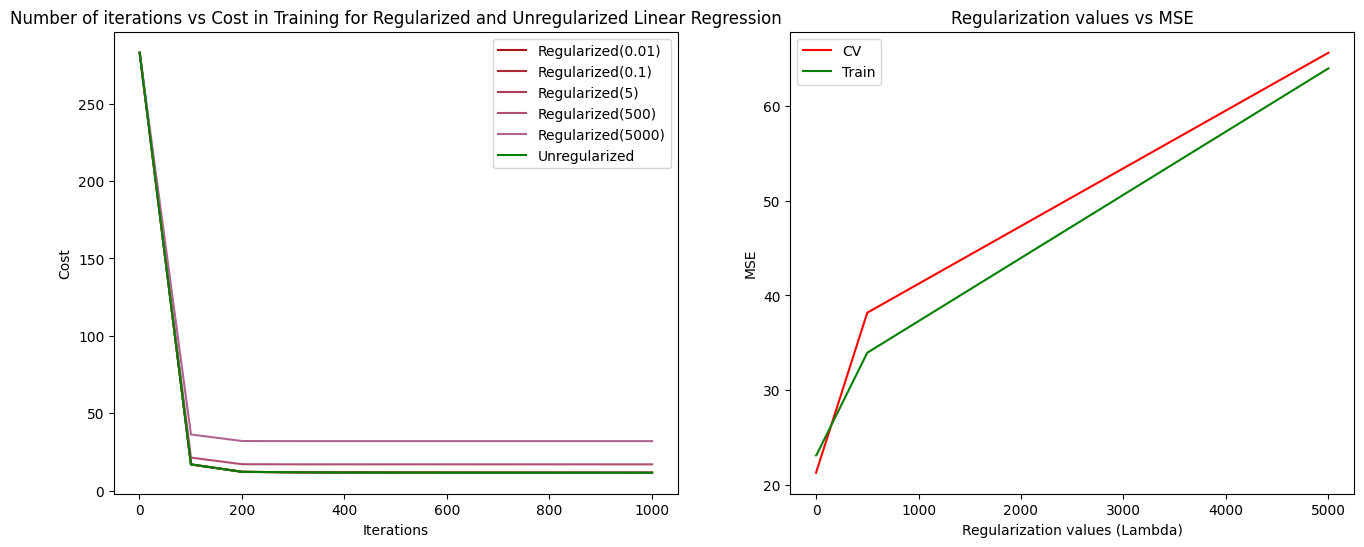

In [121]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
r, g, b = 175./255., 20./255., 25./255.
g_plus, b_plus = 20./255., 30./255.
for i in range(len(lambdas_)):
  ax[0].plot(lambdas_results[i][1], lambdas_results[i][0], c = (r, g, b), label = f'Regularized({lambdas_[i]})')
  g += g_plus
  b += b_plus
  if(g > 1):
    g -= 1
  if(b > 1):
    b-=1
ax[0].plot(cost_iters, cost_history, c = 'green', label = 'Unregularized')
ax[0].set_title('Number of iterations vs Cost in Training for Regularized and Unregularized Linear Regression')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Cost')
ax[0].legend()

ax[1].plot(lambdas_, mse_cv_lambdas, c = 'red', label = 'CV')
ax[1].plot(lambdas_, mse_train_lambdas, c = 'green', label = 'Train')
ax[1].set_title('Regularization values vs MSE')
ax[1].set_xlabel('Regularization values (Lambda)')
ax[1].set_ylabel('MSE')
ax[1].legend()
plt.show()

In [122]:
for i in range(len(lambdas_)):
  print(f'Regularization parameter: {lambdas_[i]}, MSE Train: {mse_train_lambdas[i]}, MSE CV: {mse_cv_lambdas[i]}, R-squared CV: {r2_cv_lambdas[i]}')

Regularization parameter: 0.01, MSE Train: 23.13908656362254, MSE CV: 21.30802174088954, R-squared CV: 0.7291853337475203
Regularization parameter: 0.1, MSE Train: 23.139703825353763, MSE CV: 21.31079773203926, R-squared CV: 0.7291500522405895
Regularization parameter: 5, MSE Train: 23.185563199499388, MSE CV: 21.47423133247927, R-squared CV: 0.7270728901043848
Regularization parameter: 500, MSE Train: 33.96003691228791, MSE CV: 38.18218874835401, R-squared CV: 0.5147228199588365
Regularization parameter: 5000, MSE Train: 63.94765539666094, MSE CV: 65.59790795664624, R-squared CV: 0.1662822684261812


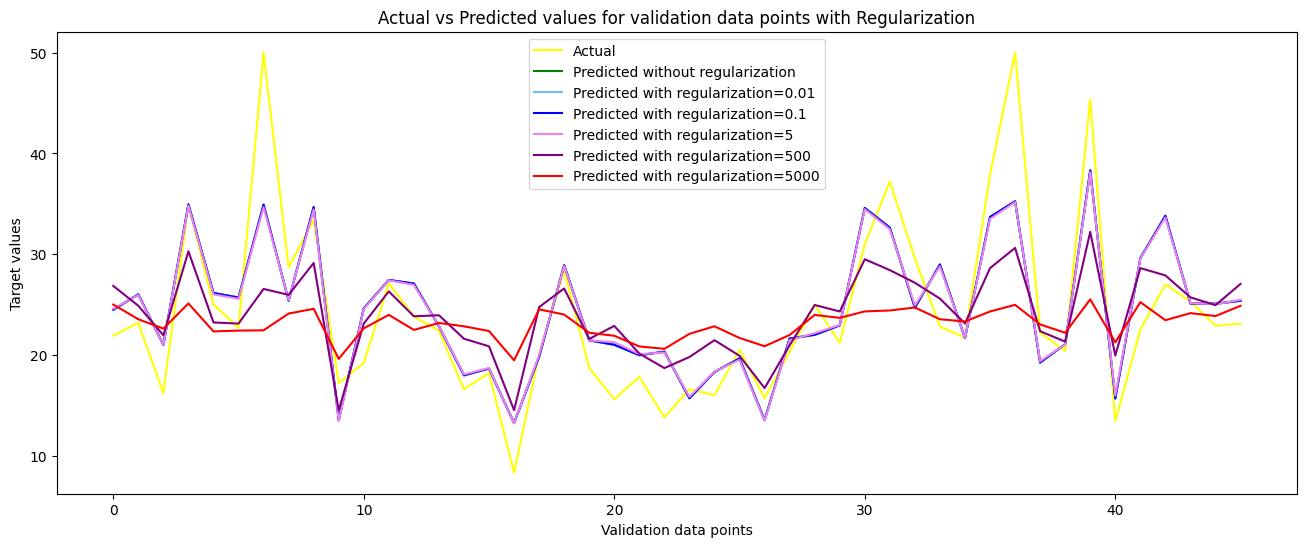

In [123]:
colors = ['xkcd:sky blue', 'blue', 'violet', 'purple', 'red']
plt.figure(figsize = (16, 6))
plt.plot(range(len(y_cv)), y_cv, c = 'yellow', label = 'Actual')
plt.plot(range(len(y_cv)), y_hat, c = 'green', label = 'Predicted without regularization')
for i in range(len(lambdas_)):
  plt.plot(range(len(y_cv)), y_pred_cv_lambdas[i], c = colors[i], label = f'Predicted with regularization={lambdas_[i]}')
plt.xlabel('Validation data points')
plt.ylabel('Target values')
plt.title('Actual vs Predicted values for validation data points with Regularization')
plt.legend()
plt.show()

In [124]:
def model_all_poly_impl(X_train, X_cv, y_train, y_cv, degree = 1):
  poly_2 = PolynomialFeatures(degree = degree, include_bias = False)
  X_train_poly_2 = poly_2.fit_transform(X_train)
  print(f"X_poly shape: {X_train_poly_2.shape}")
  print(f"No. of features: {poly_2.n_features_in_}")
  print(f"Name of features: {poly_2.feature_names_in_}")
  print(f"No. of output features: {poly_2.n_output_features_}")
  print(f"Name of output features: {poly_2.get_feature_names_out()}")
  X_cv_poly_2 = poly_2.transform(X_cv)
  scaler = StandardScaler()
  X_train_poly2_scaled = scaler.fit_transform(X_train_poly_2)
  X_cv_poly2_scaled = scaler.transform(X_cv_poly_2)
  cost_history, cost_iters, w_final, b_final = verify_regression_impl_without_regularization(np.array(X_train_poly2_scaled), np.array(y_train))
  y_pred_train = np.dot(X_train_poly2_scaled, w_final) + b_final
  y_pred_cv = np.dot(X_cv_poly2_scaled, w_final) + b_final
  mse_train = mean_squared_error(y_train, y_pred_train)
  mse_cv = mean_squared_error(y_cv, y_pred_cv)
  r2_cv = r2_score(y_cv, y_pred_cv)
  return mse_train, mse_cv, r2_cv

In [125]:
mse_train_poly2, mse_cv_poly2, r2_cv_poly2 = model_all_poly_impl(X_train, X_cv, y_train, y_cv, degree = 2)
print(f"MSE Train: {mse_train_poly2}, MSE CV: {mse_cv_poly2}, R-squared: {r2_cv_poly2}")

X_poly shape: (409, 104)
No. of features: 13
Name of features: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
No. of output features: 104
Name of output features: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT' 'CRIM^2' 'CRIM ZN' 'CRIM INDUS' 'CRIM CHAS' 'CRIM NOX'
 'CRIM RM' 'CRIM AGE' 'CRIM DIS' 'CRIM RAD' 'CRIM TAX' 'CRIM PTRATIO'
 'CRIM B' 'CRIM LSTAT' 'ZN^2' 'ZN INDUS' 'ZN CHAS' 'ZN NOX' 'ZN RM'
 'ZN AGE' 'ZN DIS' 'ZN RAD' 'ZN TAX' 'ZN PTRATIO' 'ZN B' 'ZN LSTAT'
 'INDUS^2' 'INDUS CHAS' 'INDUS NOX' 'INDUS RM' 'INDUS AGE' 'INDUS DIS'
 'INDUS RAD' 'INDUS TAX' 'INDUS PTRATIO' 'INDUS B' 'INDUS LSTAT' 'CHAS^2'
 'CHAS NOX' 'CHAS RM' 'CHAS AGE' 'CHAS DIS' 'CHAS RAD' 'CHAS TAX'
 'CHAS PTRATIO' 'CHAS B' 'CHAS LSTAT' 'NOX^2' 'NOX RM' 'NOX AGE' 'NOX DIS'
 'NOX RAD' 'NOX TAX' 'NOX PTRATIO' 'NOX B' 'NOX LSTAT' 'RM^2' 'RM AGE'
 'RM DIS' 'RM RAD' 'RM TAX' 'RM PTRATIO' 'RM B' 'RM LSTAT' 'AGE^2'
 'AGE DIS' 'AGE RAD' 'AGE 

In [126]:
def get_vif_features(X_train):
  print(X_train.columns)
  X_vif = copy.deepcopy(X_train)
  vif_data = pd.DataFrame()
  vif_data["feature"] = X_train.columns
  vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                            for i in range(len(X_train.columns))]

  print(f"VIF of features before filtering: \n{vif_data}")
  return X_vif, vif_data

def remove_features_with_vif(X_vif, vif_data):
  vif_limit = 10.0
  dropped_features = []
  while(True and len(X_vif.columns) > 0):
    highest_vif_feature = vif_data[vif_data['VIF'] == max(vif_data['VIF'])]['feature']
    dropped_features.append(highest_vif_feature)
    X_vif = X_vif.drop(highest_vif_feature, axis = 1)
    vif_data = pd.DataFrame()
    vif_data['feature'] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                          for i in range(len(X_vif.columns))]
    if vif_data[vif_data["VIF"] > vif_limit].shape[0] == 0:
      break
  print(f"VIF of features after filtering under limit {vif_limit}: \n{vif_data}")
  return X_vif.columns

In [127]:
X_vif, vif_data = get_vif_features(X_train)
selected_features_vif = remove_features_with_vif(X_vif, vif_data)
X_train_subset_vif = X_train[selected_features_vif]
scaler_vif = StandardScaler()
X_train_subset_vif_scaled = scaler_vif.fit_transform(X_train_subset_vif)
cost_history_vif, cost_iters_vif, w_final_vif, b_final_vif = verify_regression_impl_without_regularization(np.array(X_train_subset_vif_scaled), np.array(y_train))
X_cv_subset_vif_scaled = scaler_vif.transform(X_cv[selected_features_vif])
y_pred_cv_vif = np.dot(X_cv_subset_vif_scaled, w_final_vif) + b_final_vif
print(f"MSE CV: {mean_squared_error(y_cv, y_pred_cv_vif)}")
print(f"R-squared CV: {r2_score(y_cv, y_pred_cv_vif)}")

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')
VIF of features before filtering: 
    feature        VIF
0      CRIM   2.064751
1        ZN   2.975154
2     INDUS  16.895990
3      CHAS   1.148760
4       NOX  76.166040
5        RM  73.791258
6       AGE  21.508855
7       DIS  14.923889
8       RAD  16.202462
9       TAX  69.123384
10  PTRATIO  80.579078
11        B  18.131391
12    LSTAT  10.477718
VIF of features after filtering under limit 10.0: 
  feature       VIF
0    CRIM  2.057604
1      ZN  2.413185
2   INDUS  8.618026
3    CHAS  1.099417
4     DIS  8.275957
5     RAD  5.037279
6       B  9.703399
7   LSTAT  6.728981
Cost for iteration: 1: 284.94479395523604
Cost for iteration: 101: 22.0246855251505
Cost for iteration: 201: 16.327759840326706
Cost for iteration: 301: 15.925870008805488
Cost for iteration: 401: 15.828890258744325
Cost for iteration: 501: 15.795414763626184
Cost for iteration

In [128]:
def verify_forward_selection(X_train, X_cv, y_train, y_cv):
  result_fs, selected_features_fs = forward_selection(X_train, y_train, X_cv, y_cv)
  r2_cv = [result_i[1] for result_i in result_fs]
  # print(f'R-squared CV Forward Selection: {r2_cv}')
  return result_fs, selected_features_fs

In [129]:
def verify_mixed_selection(X_train, X_cv, y_train, y_cv):
  model, r2_cv, selected_features_ms = mixed_selection(X_train, y_train, X_cv, y_cv)
  # print(f'R-squared CV Mixed Selection: {r2_cv}')
  return selected_features_ms

In [130]:
result_fs, selected_features_fs = verify_forward_selection(X_train, X_cv, y_train, y_cv)
selected_features_fs_subset = selected_features_fs[:8]
X_train_subset_fs = X_train[selected_features_fs_subset]
regressor_fs = sm.OLS(y_train, X_train_subset_fs).fit()
print(f"MSE total: {regressor_fs.mse_total}")
print(f"MSE residuals: {regressor_fs.mse_resid}")
y_pred_cv_fs = regressor_fs.predict(X_cv[selected_features_fs_subset])
print(f"MSE CV: {mean_squared_error(y_cv, y_pred_cv_fs)}")
print(f"R-squared CV: {r2_score(y_cv, y_pred_cv_fs)}")
print(regressor_fs.summary())

MSE total: 594.89
MSE residuals: 27.303544326718473
MSE CV: 19.151605628259983
R-squared CV: 0.7565923411621308
                                 OLS Regression Results                                
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.954
Method:                 Least Squares   F-statistic:                              1064.
Date:                Sun, 26 Oct 2025   Prob (F-statistic):                   1.12e-264
Time:                        11:04:55   Log-Likelihood:                         -1252.6
No. Observations:                 409   AIC:                                      2521.
Df Residuals:                     401   BIC:                                      2553.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
        

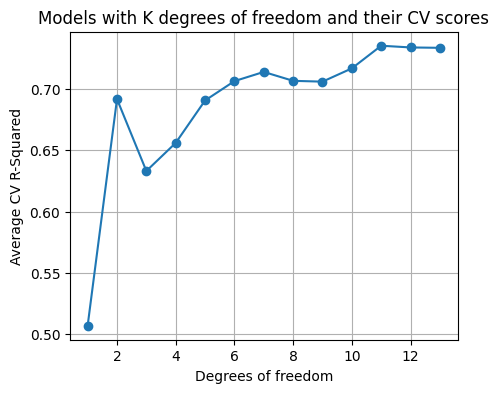

In [131]:
r2_cv_fs = [row[1] for row in result_fs]

def plot_forward_selection(r2_cv):
  plt.figure(figsize = (5, 4))
  plt.plot(range(1, len(r2_cv) + 1), r2_cv, marker = 'o')
  plt.xlabel('Degrees of freedom')
  plt.ylabel('Average CV R-Squared')
  plt.title('Models with K degrees of freedom and their CV scores')
  plt.grid(True)
  plt.show()


plot_forward_selection(r2_cv_fs)

In [132]:
selected_features_ms = verify_mixed_selection(X_train, X_cv, y_train, y_cv)
X_train_subset_ms = X_train[selected_features_ms]
regressor_ms = sm.OLS(y_train, X_train_subset_ms).fit()
print(f"MSE total: {regressor_ms.mse_total}")
print(f"MSE residuals: {regressor_ms.mse_resid}")
y_pred_cv_ms_lib = regressor_ms.predict(X_cv[selected_features_ms])
print(f"MSE CV: {mean_squared_error(y_cv, y_pred_cv_ms_lib)}")
print(f"R-squared CV: {r2_score(y_cv, y_pred_cv_ms_lib)}")
print(regressor_ms.summary())

MSE total: 594.89
MSE residuals: 29.385842887068364
MSE CV: 17.10218859475166
R-squared CV: 0.7826394419531277
                                 OLS Regression Results                                
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              875.5
Date:                Sun, 26 Oct 2025   Prob (F-statistic):                   5.47e-257
Time:                        11:04:56   Log-Likelihood:                         -1267.1
No. Observations:                 409   AIC:                                      2552.
Df Residuals:                     400   BIC:                                      2588.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
         

In [133]:
def model_linear_regression(X_train, X_cv, y_train, y_cv):
  regressor = sm.OLS(y_train, X_train).fit()
  y_pred_cv = regressor.predict(X_cv)
  y_pred_train = regressor.predict(X_train)
  mse_cv = mean_squared_error(y_cv, y_pred_cv)
  mse_train = mean_squared_error(y_train, y_pred_train)
  r2_cv = r2_score(y_cv, y_pred_cv)
  return regressor, mse_train, mse_cv, r2_cv

In [134]:
def verify_regression_with_regularization(X_train, y_train, X_cv, y_cv, lambda_ = 0):
  ridge_model = Ridge(alpha = lambda_)
  ridge_model.fit(X_train, y_train)
  cv_score_ridge = ridge_model.score(X_cv, y_cv)

  lasso_model = Ridge(alpha = lambda_)
  lasso_model.fit(X_train, y_train)
  cv_score_lasso = lasso_model.score(X_cv, y_cv)

  return cv_score_ridge, cv_score_lasso

In [135]:
def model_all_poly(X_train, X_cv, y_train, y_cv, degree = 1):
  poly_2 = PolynomialFeatures(degree = degree, include_bias = False)
  X_train_poly_2 = poly_2.fit_transform(X_train)
  print(f"X_poly shape: {X_train_poly_2.shape}")
  print(f"No. of features: {poly_2.n_features_in_}")
  print(f"Name of features: {poly_2.feature_names_in_}")
  print(f"No. of output features: {poly_2.n_output_features_}")
  print(f"Name of output features: {poly_2.get_feature_names_out()}")
  X_cv_poly_2 = poly_2.transform(X_cv)
  _, mse_train, mse_cv, r2_cv = model_linear_regression(X_train_poly_2, X_cv_poly_2, y_train, y_cv)
  return mse_train, mse_cv, r2_cv

In [136]:
def k_folds_cv(X, y, folds = 5, random_state = 0):
  spl = get_k_fold_cv(folds, random_state, X, y)
  all_folds_data = {}
  for i, (train_index, cv_index) in enumerate(spl):
    X_train, X_cv = X.iloc[train_index, :], X.iloc[cv_index, :]
    y_train, y_cv = y.iloc[train_index], y.iloc[cv_index]
    print(f"Data size: {X_train.shape}, {X_cv.shape}, {y_train.shape}, {y_cv.shape}")
    all_folds_data[i] = (X_train, X_cv, y_train, y_cv)
  return all_folds_data

folds = 5
state = 42

all_folds_data = k_folds_cv(X_train_cv, y_train_cv, folds, state)

mse_train_all_folds = []
mse_cv_all_folds = []
r2_cv_all_folds = []

mse_train_poly_2_all_folds = []
mse_cv_poly_2_all_folds = []
r2_cv_poly_2_all_folds = []

reg_all_folds = {}
for lambda_ in lambdas_:
  reg_all_folds[lambda_] = []

mse_train_poly2_all_folds = []
mse_cv_poly2_all_folds = []
r2_cv_poly2_all_folds = []

mse_train_vif_all_folds = []
mse_cv_vif_all_folds = []
r2_cv_vif_all_folds = []

mse_train_fs_all_folds = []
mse_cv_fs_all_folds = []
r2_cv_fs_all_folds = []

mse_train_ms_all_folds = []
mse_cv_ms_all_folds = []
r2_cv_ms_all_folds = []

for k in all_folds_data:
  print(f"\n*********** Fold: {k} ****************\n")
  X_train, X_cv, y_train, y_cv = all_folds_data[k][0], all_folds_data[k][1], all_folds_data[k][2], all_folds_data[k][3]
  _, mse_train, mse_cv, r2_cv = model_linear_regression(X_train, X_cv, y_train, y_cv)
  mse_train_all_folds.append(mse_train); mse_cv_all_folds.append(mse_cv); r2_cv_all_folds.append(r2_cv)
  for lambda_ in lambdas_:
    ridge_score, lasso_score = verify_regression_with_regularization(X_train, y_train, X_cv, y_cv, lambda_)
    reg_all_folds[lambda_].append([ridge_score, lasso_score])

  mse_train_poly2, mse_cv_poly2, r2_cv_poly2 = model_all_poly(X_train, X_cv, y_train, y_cv, degree = 2)
  mse_train_poly2_all_folds.append(mse_train_poly2); mse_cv_poly2_all_folds.append(mse_cv_poly2); r2_cv_poly2_all_folds.append(r2_cv_poly2)

  X_vif, vif_data = get_vif_features(X_train)
  selected_features_vif = remove_features_with_vif(X_vif, vif_data)
  print(f"Selected Features VIF: {selected_features_vif}")

  X_train_vif, X_cv_vif = X_train.loc[:, selected_features_vif], X_cv.loc[:, selected_features_vif]
  _, mse_train_vif, mse_cv_vif, r2_cv_vif = model_linear_regression(X_train_vif, X_cv_vif, y_train, y_cv)
  mse_train_vif_all_folds.append(mse_train_vif); mse_cv_vif_all_folds.append(mse_cv_vif); r2_cv_vif_all_folds.append(r2_cv_vif)

  result_fs, selected_features_fs = verify_forward_selection(X_train, X_cv, y_train, y_cv)
  selected_features_fs_subset = selected_features_fs[:8]
  X_train_fs, X_cv_fs = X_train.loc[:, selected_features_fs_subset], X_cv.loc[:, selected_features_fs_subset]
  _, mse_train_fs, mse_cv_fs, r2_cv_fs = model_linear_regression(X_train_fs, X_cv_fs, y_train, y_cv)
  mse_train_fs_all_folds.append(mse_train_fs); mse_cv_fs_all_folds.append(mse_cv_fs); r2_cv_fs_all_folds.append(r2_cv_fs)

  selected_features_ms = verify_mixed_selection(X_train, X_cv, y_train, y_cv)
  X_train_ms, X_cv_ms = X_train.loc[:, selected_features_ms], X_cv.loc[:, selected_features_ms]
  _, mse_train_ms, mse_cv_ms, r2_cv_ms = model_linear_regression(X_train_ms, X_cv_ms, y_train, y_cv)
  mse_train_ms_all_folds.append(mse_train_ms); mse_cv_ms_all_folds.append(mse_cv_ms); r2_cv_ms_all_folds.append(r2_cv_ms)

print(f"\nWith all the features\n - MSE Train: {np.mean(mse_train_all_folds)}, MSE CV: {np.mean(mse_cv_all_folds)}, R-squared CV: {np.mean(r2_cv_all_folds)}")
for lambda_ in lambdas_:
  print(f"Regularization: {lambda_}, {folds}-folds [Ridge score, Lasso score]: {reg_all_folds[lambda_]}")
print(f"\nWith polynomial features\n - MSE Train: {np.mean(mse_train_poly2_all_folds)}, MSE CV: {np.mean(mse_cv_poly2_all_folds)}, R-squared CV: {np.mean(r2_cv_poly2_all_folds)}")
print(f"\nWith VIF: Selected features - {selected_features_vif}\n - MSE Train: {np.mean(mse_train_vif_all_folds)}, MSE CV: {np.mean(mse_cv_vif_all_folds)}, R-squared CV: {np.mean(r2_cv_vif_all_folds)}")
print(f"\nWith Forward selection: Selected features - {selected_features_fs}\n - MSE Train: {np.mean(mse_train_fs_all_folds)}, MSE CV: {np.mean(mse_cv_fs_all_folds)}, R-squared CV: {np.mean(r2_cv_fs_all_folds)}")
print(f"\nWith Mixed selection: Selected features - {selected_features_ms}\n - MSE Train: {np.mean(mse_train_ms_all_folds)}, MSE CV: {np.mean(mse_cv_ms_all_folds)}, R-squared CV: {np.mean(r2_cv_ms_all_folds)}")

Data size: (364, 13), (91, 13), (364,), (91,)
Data size: (364, 13), (91, 13), (364,), (91,)
Data size: (364, 13), (91, 13), (364,), (91,)
Data size: (364, 13), (91, 13), (364,), (91,)
Data size: (364, 13), (91, 13), (364,), (91,)

*********** Fold: 0 ****************

X_poly shape: (364, 104)
No. of features: 13
Name of features: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
No. of output features: 104
Name of output features: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT' 'CRIM^2' 'CRIM ZN' 'CRIM INDUS' 'CRIM CHAS' 'CRIM NOX'
 'CRIM RM' 'CRIM AGE' 'CRIM DIS' 'CRIM RAD' 'CRIM TAX' 'CRIM PTRATIO'
 'CRIM B' 'CRIM LSTAT' 'ZN^2' 'ZN INDUS' 'ZN CHAS' 'ZN NOX' 'ZN RM'
 'ZN AGE' 'ZN DIS' 'ZN RAD' 'ZN TAX' 'ZN PTRATIO' 'ZN B' 'ZN LSTAT'
 'INDUS^2' 'INDUS CHAS' 'INDUS NOX' 'INDUS RM' 'INDUS AGE' 'INDUS DIS'
 'INDUS RAD' 'INDUS TAX' 'INDUS PTRATIO' 'INDUS B' 'INDUS LSTAT' 'CHAS^2'
 'CHAS NOX' 'CHAS RM' 'CHAS AGE' 'CH

Comment: the model with polynomial features has performed best compared to other models (cross-validation MSE = 22.80, R-squared = 0.75)